In [1]:
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import vip_hci as vip
from hciplot import plot_frames, plot_cubes
from vip_hci.conf.param import KECK_NIRC2

plt.style.use(["fivethirtyeight", "seaborn-notebook"])
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Steps

1. Get the aperture photometry for the unnormalized PSF (aka the Star)
2. Get the aperture photometry for the planet (do this via Negfc fitting the residual)
    a. What are the parameters for the fit? Is it a scalar multiple? An aperture flux? look this up in the code
3. Find magnitude difference (for L' band)
4. Find magnitude of star using papers/catalogues
5. Use (3) to find mag of planet
6. Use parallax to get abs. mag
7. Use 225 Myr + (COND, BT-SETTL) tables to get $M/M_\odot$
8. Convert to $M_J$
9. ???
10. Profit

In [2]:
ds9 = vip.Ds9Window()

## Load Data

In [3]:
base_path = "../data/2020feb04/processed"

In [4]:
cube = np.delete(fits.getdata(join(base_path, "cube_crop.fits")), slice(80, 131), 0)
angles = np.delete(fits.getdata(join(base_path, "par_angles.fits")), slice(80, 131), 0)

In [5]:
ds9.display(cube)

# Negative Companion Modeling

## PSF

In [6]:
# build PSF model (median centered star)
# Median filter PSF model
# use this "final model" as a fake companion by injecting the _negative_ PSF model (check docstrings!!!! [or probably code])

In [7]:
fwhm = 8.41
psf = vip.metrics.collapse_psf_cube(cube, 64, fwhm=fwhm)

New shape: (154, 64, 64)
`Force_odd` is True therefore `size` was set to 65
Flux in 1xFWHM aperture: 1912745.838
Done scaled PSF template from the average of 154 frames.


In [8]:
ds9.display(psf)

/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/hciplot/hciplot.py:398: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(rows, cols, v)


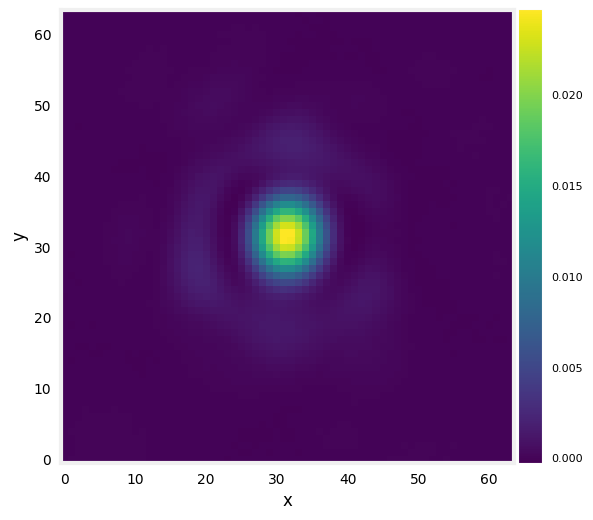

In [9]:
plot_frames(psf)

## By Hand

> something something "if you want it done right" something something "do it yourself"

In [10]:
orig_red = vip.pca.pca(cube, angles, ncomp=27, fwhm=fwhm, mask_center_px=fwhm)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-19 18:00:46
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 5.341 GB
Done vectorizing the frames. Matrix shape: (154, 65536)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.969848
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:01.511523
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


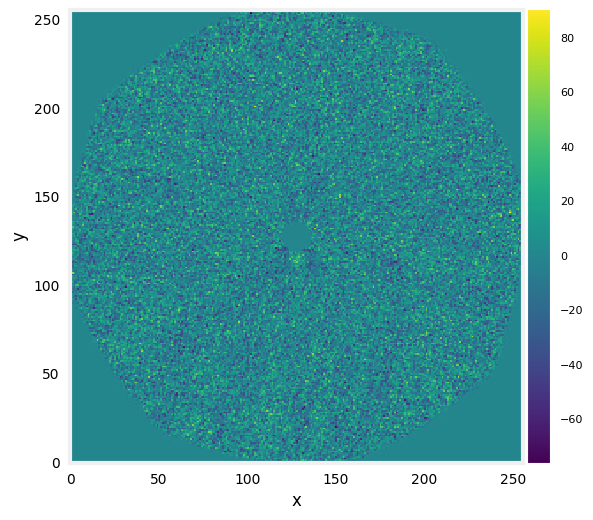

In [11]:
plot_frames(orig_red)

In [12]:
ds9.display(orig_red)

In [13]:
x, y = 128, 113.875
r = np.sqrt((x - 127.5)**2 + (y - 127.5)**2)
theta = np.rad2deg(np.arctan2(y - 127.5, x - 127.5))
print(theta)
f = 7000
cube_emp_hand = vip.negfc.cube_planet_free(
    [([r], [theta], [f])], cube, angles, psf, KECK_NIRC2["plsc_narrow"]
)

-87.89834567232872


In [14]:
cube_emp_hand_red = vip.pca.pca(
    cube_emp_hand, angles, ncomp=27, fwhm=fwhm, mask_center_px=fwhm
)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-19 18:00:49
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 5.515 GB
Done vectorizing the frames. Matrix shape: (154, 65536)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:01.063798
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:01.615510
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [15]:
ds9.display(orig_red, cube_emp_hand_red)

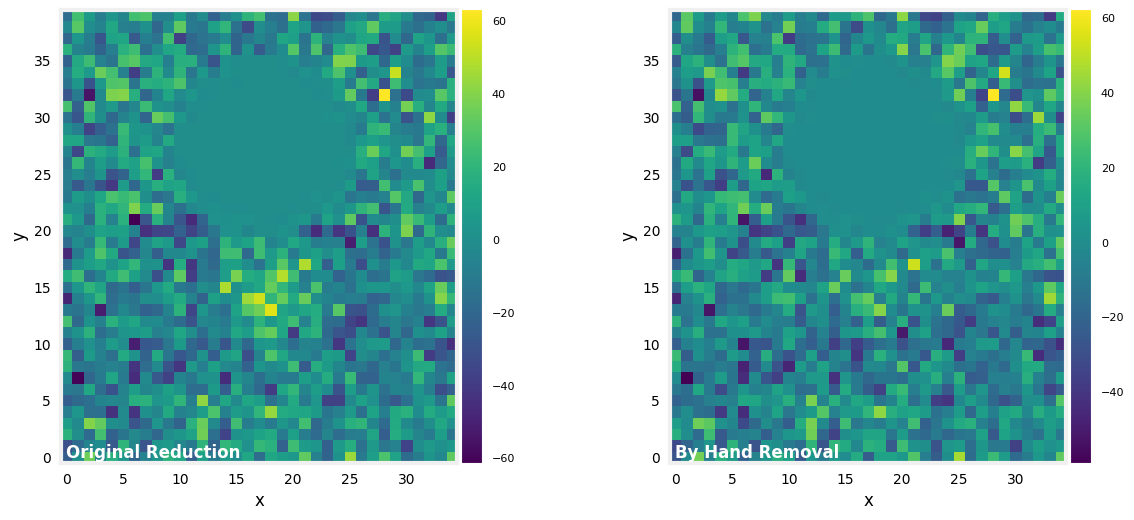

In [16]:
idx = (slice(100, 140), slice(110, 145))
plot_frames(
    (orig_red[idx], cube_emp_hand_red[idx]),
    label=("Original Reduction", "By Hand Removal"),
)

## MAP Estimate

In [17]:
fg = vip.negfc.firstguess(
    cube,
    angles,
    psf,
    ncomp=27,
    fwhm=fwhm,
    annulus_width=4,
    aperture_radius=1.2,
    plsc=KECK_NIRC2["plsc_narrow"],
    planets_xy_coord=[(127, 113)],
    f_range=np.arange(3000, 10001, 500)
)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-19 18:00:52
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [127,113], running ...
Step | flux    | chi2r
1/15   3000.000   6.522
2/15   3500.000   6.425
3/15   4000.000   6.351
4/15   4500.000   6.279
5/15   5000.000   6.298
6/15   5500.000   6.341
7/15   6000.000   6.418
Planet 0: preliminary guess: (r, theta, f)=(14.5, 268.0, 4500.0)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 59, nfev: 174, chi2r: 6.13832272765457
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(15.100, 267.410, 4662.465) at 
          (X,Y)=(126.82, 112.42)

 ――――――

In [18]:
cube_emp_fg = vip.negfc.cube_planet_free(
    [fg], cube, angles, psf, KECK_NIRC2["plsc_narrow"]
)

In [19]:
cube_emp_fg_red = vip.pca.pca(
    cube_emp_fg, angles, ncomp=27, fwhm=fwhm, mask_center_px=fwhm
)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-19 18:03:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 5.610 GB
Done vectorizing the frames. Matrix shape: (154, 65536)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.933259
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:01.475534
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


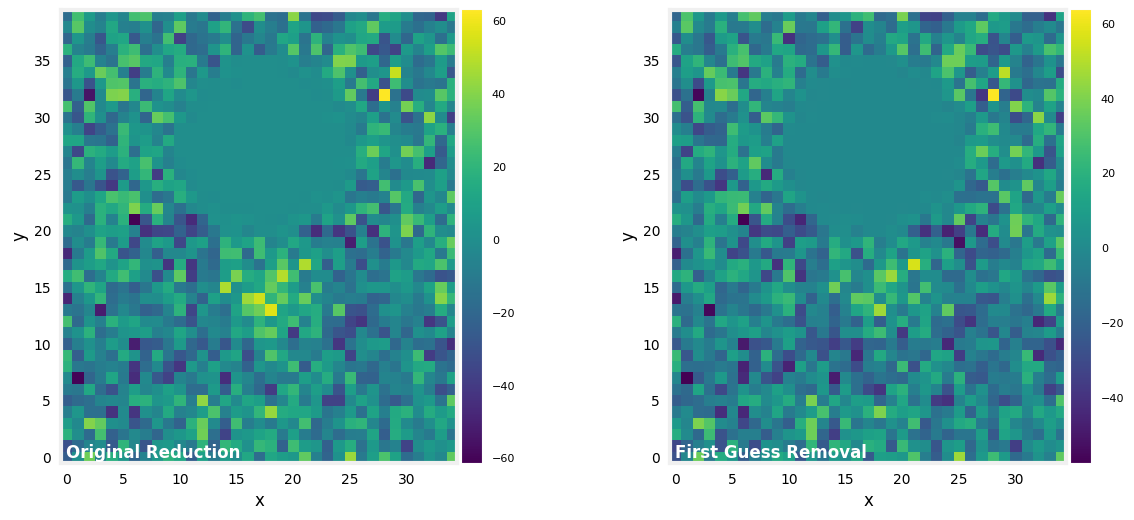

In [20]:
idx = (slice(100, 140), slice(110, 145))
plot_frames(
    (orig_red[idx], cube_emp_fg_red[idx]),
    label=("Original Reduction", "First Guess Removal"),
)

## Nested Sampling

In [21]:
init = (fg[0][0], fg[1][0], fg[2][0])

nested_res = vip.negfc.nested_negfc_sampling(
    init,
    cube,
    angles,
    plsc=KECK_NIRC2["plsc_narrow"],
    psf=psf,
    fwhm=fwhm,
    annulus_width=3,
    aperture_radius=1.5,
    ncomp=27,
    npoints=200,
    dlogz=0.5
)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-19 18:03:50
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Prior bounds on parameters:
Radius [10.100248559143072,20.100248559143072]
Theta [262.4102112277677,272.4102112277677]
Flux [4462.464602348941,4862.464602348941]

Using 200 active points

Total running time:
Running time:  4:26:43.417449
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


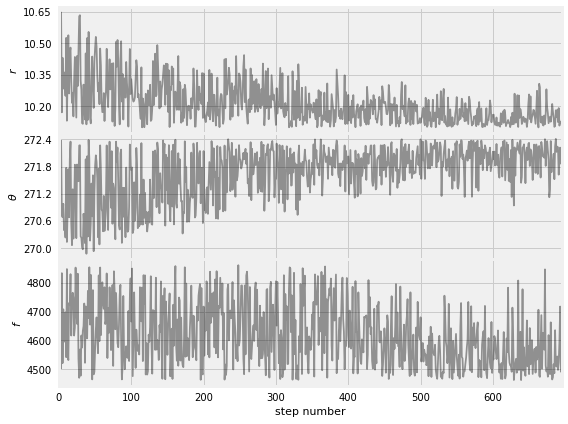

In [35]:
chain = nested_res.samples[np.newaxis, 1000:, :]

vip.negfc.show_walk_plot(chain)

percentage for r: 95.10791366906471%
percentage for theta: 95.2517985611511%
percentage for flux: 95.2517985611511%


Confidence intervals:
r: 10.113948983433184 [-0.013620693422545571,0.36231044503970544]
theta: 272.27080048182 [-2.085544172446305,0.13903627816307562]
flux: 4464.661450667441 [-1.9900818593441727,392.0461262908566]


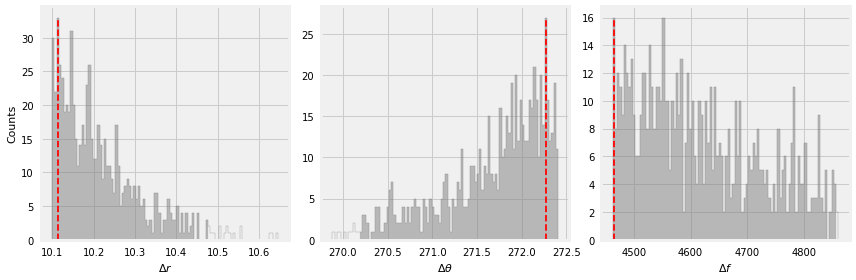

In [36]:
mcmc_map, ci = vip.negfc.confidence(chain[0], cfd=95)

In [37]:
params = [([mcmc_map["r"]], [mcmc_map["theta"]], [mcmc_map["f"]])]
cube_emp_nest = vip.negfc.cube_planet_free(
    params, cube, angles, psf, KECK_NIRC2["plsc_narrow"]
)

In [38]:
cube_emp_nest_red = vip.pca.pca(
    cube_emp_nest, angles, ncomp=27, fwhm=fwhm, mask_center_px=fwhm
)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-20 01:08:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 5.993 GB
Done vectorizing the frames. Matrix shape: (154, 65536)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:01.030278
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:01.597458
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


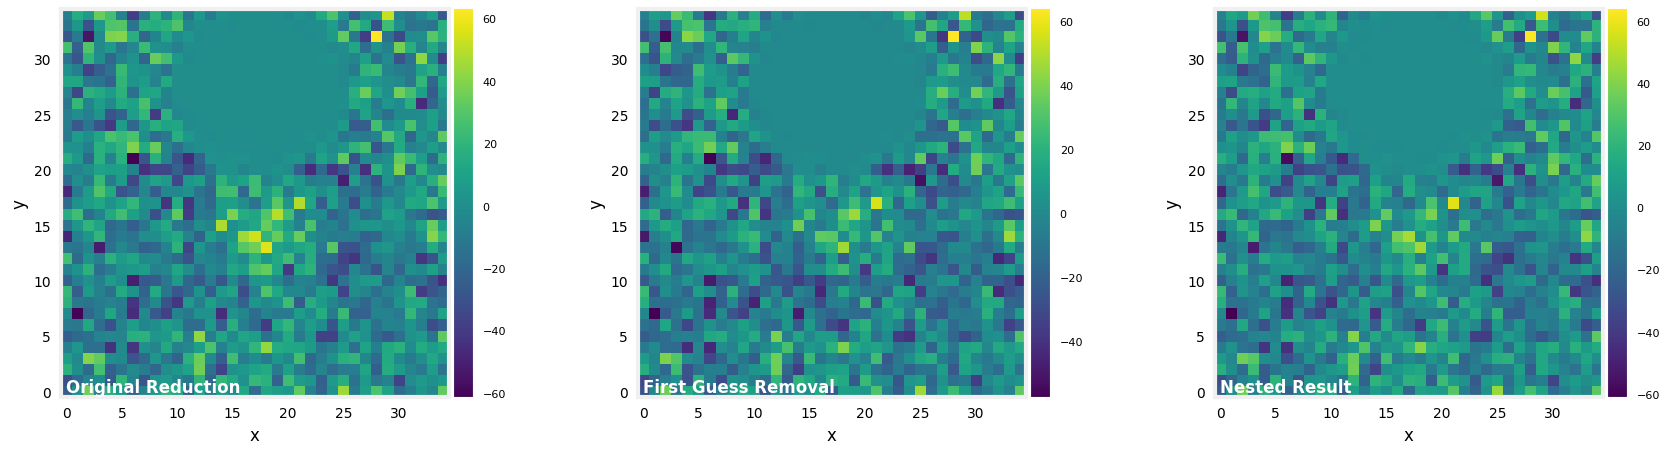

In [39]:
idx = (slice(100, 135), slice(110, 145))
plot_frames(
    (orig_red[idx], cube_emp_fg_red[idx], cube_emp_nest_red[idx]),
    label=("Original Reduction", "First Guess Removal", "Nested Result"),
)

# Photometry and Calculations

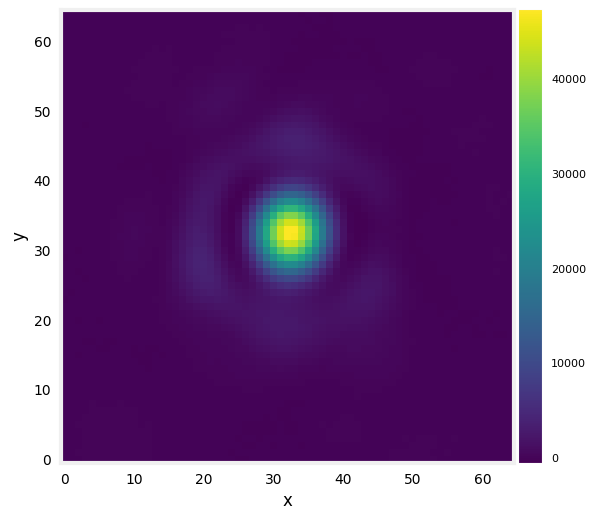

In [40]:
plot_frames(np.mean(cube, axis=0)[95:160, 95:160])

In [52]:
star_flux = np.mean(cube, axis=0)[95:160, 95:160].sum()
plan_flux = psf.sum() * mcmc_map["f"]
# from Gaia dr2 2018yCat.1345....0G
d = 1 / 0.3766801
μ = 5 * np.log10(d / 10)
Δmag = -2.5 * np.log10(plan_flux / star_flux)
Δmag

6.579153284916426

In [53]:
from scipy.interpolate import InterpolatedUnivariateSpline

# from https://arxiv.org/pdf/0809.4871.pdf
S = InterpolatedUnivariateSpline([1.215, 1.654, 2.157], [9.14, 9.17, 9.01], k=1)
star_mag = S(3.776)
plan_mag = star_mag + Δmag
print(f"Star Mag: {star_mag}\nPlanet Mag: {plan_mag}")

Star Mag: 8.49500994035785
Planet Mag: 15.074163225274276


In [54]:
star_abs_mag = star_mag - μ
plan_abs_mag = plan_mag - μ
print(f"Star Abs Mag: {star_abs_mag}\nPlanet Abs Mag: {plan_abs_mag}")

Star Abs Mag: 11.374873325572803
Planet Abs Mag: 17.95402661048923


In [63]:
# at 225 Myr 
Cond_M = InterpolatedUnivariateSpline([17.329, 18.821], [0.0020, 0.0010], k=1)
M_plan = Cond_M(plan_abs_mag) / 0.0009543 # to jupiter mass
print(f"Planet mass (Cond): {M_plan} M_J")

Planet mass (Cond): 1.6567969823555604 M_J
